# 5. Example: 4DVar Backprop DA using Reservoir Computing ML Model on QGS Model - RayTune for HyperParams

Using Reservoir Computing model macro-parameters from QGS/Jason Platt's paper: Platt, J. A., Wong, A., Clark, R., Penny, S. G. & Abarbanel, H. D. I. Robust forecasting using predictive generalized synchronization in reservoir computing. Chaos: An Interdisciplinary Journal of Nonlinear Science 31, 123118 (2021).


In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from qgs.params.params import QgParams
import pandas as pd

from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

In [2]:
%%bash
# Make output dir
mkdir -p out/qgs

In [3]:
random_seed=50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [4]:
# Time parameters
dt = 0.5
# transient time to attractor
transient_time = 1.e5
# integration time on the attractor
integration_time = 1.e4


# Setting some model parameters
# Model parameters instantiation with some non-default specs
model_params = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_params.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_params.ground_params.set_orography(0.2, 1)
model_params.atemperature_params.set_thetas(0.2, 0)

In [5]:
train_size = 100000
transient_size = 1000
valid_size = 10000
test_size = 10000

In [6]:
nature_run = dab.data.QGS(model_params=model_params, store_as_jax=False, delta_t=dt,
                          random_seed=random_seed)
nature_run.generate(n_steps=200*1000, stride=1000, x0=np_rng.random(model_params.ndim)*0.001, mxstep=5000)
x0 = nature_run.values[-1]

In [7]:
nature_run.generate(x0=x0, n_steps=(train_size +  valid_size + transient_size + test_size), mxstep=5000)

In [8]:
# NOTE: This raises a Parameter dimensional conversion warning that can be safely ignored
nr_train, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    train_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


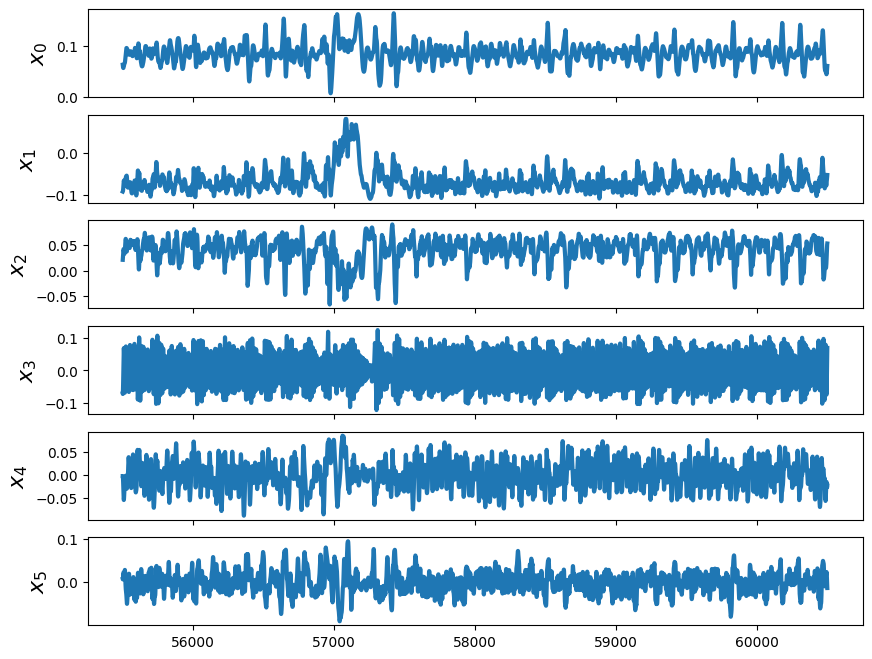

In [9]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
#     ax.set_xlim(54000, 55000)

## B. Generate Observations

In [10]:
# First we need to calculate the per-variable SD for QGS model
obs_sd_scale = 0.1
per_variable_sd = np.std(nr_train.values, axis=0)
obs_sd = 0.1*per_variable_sd

In [11]:
# Now we can define the observer:
obs_qgs_test = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd, 
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Now we can define the observer:
obs_qgs_valid = dab.observer.Observer(
    nr_valid, # Data generator object
    time_indices = np.arange(0, nr_valid.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd,  
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_valid = obs_qgs_valid.observe()
obs_vec_test = obs_qgs_test.observe()

## C. Define and train model

In [12]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=20, 
    reservoir_dim=2000, 
    input_dim=20, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.98765777241154,
    sigma_bias = 0.675882947305197,
    spectral_radius =  0.376752115791648, # SR 
    leak_rate=0.5343730100231164, # alpha
    log_beta=-20.219432227197363)

In [13]:
# # # Train: Takes a few minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('./out/qgs/rc_weights.pkl')

In [14]:
# Shortcut: load the W_out weights from previous training
weights_path = './out/qgs/rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

## D. Set up and run DA Cycler for validation period

In [15]:
# Getting standard deviation of reservoir state values for sigma_bg
train_res_values = forecast_model.generate(nr_train.values)
train_res_sd = np.std(train_res_values, axis=0)

In [16]:
sigma_obs=obs_sd[obs_vec_valid.location_indices[0]]*1.25
sigma_bg = 0.1*train_res_sd 

R = (sigma_obs**2)*np.identity(sigma_obs.shape[0])
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_valid.location_indices[0], 1)] = 1
H = S @ forecast_model.Wout.T

In [17]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_train.values[-1000:]
        + np.random.normal(size = (1000, nr_train.system_dim), scale=obs_sd))[-1], nr_train.values[-1])

In [18]:
def raytune_v4d_bp_valid(config, num_iters, H, B, R, 
                         delta_t, forecast_model, r0_original,
                         nr, obs_vec, sigma_obs):
    
    dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=config['lr'],
    lr_decay=config['lr_decay'],
    num_iters=num_iters,
    model_obj=forecast_model,
    obs_window_indices=[0,2,5,8],
    steps_per_window=10, # 10 instead of 9 because inclusive of start and end
    )
    cur_tstep = 0

    r0_sv = dab.vector.StateVector(
        values=r0_original,
        store_as_jax=True)

    out_statevec = dc.cycle(
        input_state = r0_sv,
        start_time = nr.times[cur_tstep],
        obs_vector = obs_vec,
        analysis_window=4.5,
        timesteps=int(nr_valid.time_dim/9)-2,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=2.25)
        
    rmse = np.sqrt(np.mean(np.square(nr.values[:-19] - forecast_model.readout(out_statevec.values))))
    
    train.report({'rmse':rmse})

### RayTune

In [19]:
space = {
    "lr": hp.loguniform("lr", -10, 0),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.99),
}
num_iters = 3

In [20]:
trainable_w_num_iters = tune.with_parameters(raytune_v4d_bp_valid, 
                                              delta_t=nature_run.delta_t,
                                              num_iters=num_iters,
                                              H=H,
                                              B=B,
                                              R=R,
                                              forecast_model=forecast_model,
                                              r0_original=r0_original,
                                              sigma_obs=sigma_obs,
                                              obs_vec=obs_vec_valid,
                                              nr=nr_valid
                                             )

In [21]:
hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min")
tuner = tune.Tuner(
    trainable_w_num_iters,
    tune_config=tune.TuneConfig(
        num_samples=50,
        max_concurrent_trials=1,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()

cur_results_df = results.get_dataframe()

cur_results_df['num_iters'] = num_iters

(pid=199824) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=199824)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=199824) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=199824)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=199824) [[82.56620182 37.06430455 33.93579261]
(raytune_v4d_bp_valid pid=199824)  [53.97360014 36.73629038 33.9215726 ]
(raytune_v4d_bp_valid pid=199824)  [37.8747656  25.59932042 24.25685373]
(raytune_v4d_bp_valid pid=199824)  ...
(raytune_v4d_bp_valid pid=199824)  [48.18331339 39.19315511 36.65092231]
(raytune_v4d_bp_valid pid=199824)  [45.11295891 39.29352575 37.32345812]
(raytune_v4d_bp_valid pid=199824)  [44.73411035 39.38508437 37.72906096]]


(pid=200854) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=200854)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=200854) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=200854)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=200854) [[ 82.56620182  73.00886154  71.08187392]
(raytune_v4d_bp_valid pid=200854)  [ 83.55067033  76.61686972  75.19144478]
(raytune_v4d_bp_valid pid=200854)  [ 50.70492068  47.39779519  46.68829011]
(raytune_v4d_bp_valid pid=200854)  [693.60838011 643.47899034 633.27310975]
(raytune_v4d_bp_valid pid=200854)  [731.30875361 667.75819474 655.08933144]
(raytune_v4d_bp_valid pid=200854)  [908.14178444 837.31240424 822.05489261]]
(raytune_v4d_bp_valid pid=200854)  ...


(pid=201560) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=201560)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=201560) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=201560)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=201560)  [  93.1977534    91.75930653   90.5952944 ]
(raytune_v4d_bp_valid pid=201560)  ...
(raytune_v4d_bp_valid pid=201560)  [9489.50051659 9384.25867261 9298.46694744]
(raytune_v4d_bp_valid pid=201560)  [8446.18791582 8355.14248126 8282.97654716]
(raytune_v4d_bp_valid pid=201560)  [5313.25410253 5274.82609731 5243.33965581]]
(raytune_v4d_bp_valid pid=201560) [[  82.56620182   80.87492075   79.51033762]
(raytune_v4d_bp_valid pid=201560)  [  54.68053615   54.11578882   53.65402854]


(pid=202023) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=202023) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=202023)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=202023) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=202023)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:08:03,005	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_827bd7b9
Traceback (most recent call last):
  File "/home/ksolvik/min

(raytune_v4d_bp_valid pid=202512) [[82.56620182 40.77815407 32.08818324]
(raytune_v4d_bp_valid pid=202512)  [50.41944965 33.46407727 31.70688674]
(raytune_v4d_bp_valid pid=202512)  [37.36028839 24.5333791  23.7084332 ]
(raytune_v4d_bp_valid pid=202512)  [50.15904457 40.58237061 35.44814379]
(raytune_v4d_bp_valid pid=202512)  [46.74983285 39.34570255 36.88675203]
(raytune_v4d_bp_valid pid=202512)  [42.75157495 37.02958965 34.99013246]]
(raytune_v4d_bp_valid pid=202512)  ...


(pid=203313) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=203313) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=203313)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=203313) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=203313)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=203313) [[  82.56620182   74.98903684   71.24290391]
(raytune_v4d_bp_valid pid=203313)  [  81.856944     76.53704382   73.86244162]
(raytune_v4d_bp_valid pid=203313)  [  50.20408994   47.57389972   46.20607181]
(raytune_v4d_bp_valid pid=203313)  ...
(raytune_v4d_bp_valid pid=203313)  [5340.69996834 5260.88674216 5216.30924816]
(raytune_v4d_bp_valid pid=203313)  [6847.07950466 6522.00711829 6354.83217931]
(raytune_v4d_bp_valid pid=203313)  [4170.05952025 4061.4540389  4001.48655464]]


(pid=204374) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=204374) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=204374)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=204374) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=204374)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=204374)  [6111.31602522 6019.44891529 5964.21464103]
(raytune_v4d_bp_valid pid=204374)  [4691.45521528 4538.66999039 4451.34407425]
(raytune_v4d_bp_valid pid=204374)  [4712.01040089 4577.53241626 4497.73253384]]
(raytune_v4d_bp_valid pid=204374) [[  82.56620182   77.14307286   74.12418975]
(raytune_v4d_bp_valid pid=204374)  [  51.39691427   49.55313517   48.48720168] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(raytune_v4d_bp_valid pid=204374)  ...


(pid=204900) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=204900) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=204900)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=204900) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=204900)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=204900) [[  82.56620182   82.2485718    82.18583682]
(raytune_v4d_bp_valid pid=204900)  ...
(raytune_v4d_bp_valid pid=204900)  [3930.03081922 3923.8682938  3922.64835167]
(raytune_v4d_bp_valid pid=204900)  [2781.17323456 2777.94427617 2777.30424293]
(raytune_v4d_bp_valid pid=204900)  [1666.69952554 1663.85128153 1663.28744758]]
(raytune_v4d_bp_valid pid=204900)  [  57.44251401   57.33554162   57.31436745] [repeated 2x across cluster]


(pid=205407) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=205407) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=205407)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=205407) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=205407)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=205407)  [4806.16348364 4756.69434239 4727.25607057]
(raytune_v4d_bp_valid pid=205407)  [5440.39235354 5291.17332582 5206.58746837]
(raytune_v4d_bp_valid pid=205407)  [5640.74146034 5325.61625045 5153.05922132]]
(raytune_v4d_bp_valid pid=205407) [[  82.56620182   78.41280413   76.07818772]
(raytune_v4d_bp_valid pid=205407)  ...
(raytune_v4d_bp_valid pid=205407)  [  52.51840099   51.12089745   50.31165494] [repeated 2x across cluster]


(pid=206145) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=206145) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=206145)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=206145) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=206145)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=206145) [[  82.56620182   80.01166606   78.91417592]
(raytune_v4d_bp_valid pid=206145)  ...
(raytune_v4d_bp_valid pid=206145)  [9513.39332532 9430.0087967  9392.97031423]
(raytune_v4d_bp_valid pid=206145)  [9289.0400471  9196.49134767 9155.9516814 ]
(raytune_v4d_bp_valid pid=206145)  [9198.02029699 9062.63378227 9004.11849526]]
(raytune_v4d_bp_valid pid=206145)  [  54.69837865   53.843797     53.46985106] [repeated 2x across cluster]


(pid=206940) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=206940) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=206940)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=206940) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=206940)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:27:06,507	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_3c67aa0d
Traceback (most recent call last):
  File "/home/ksolvik/min

(raytune_v4d_bp_valid pid=207244)  [7133.50232783 7099.93039382 7090.11919872]
(raytune_v4d_bp_valid pid=207244)  [6523.93794066 6480.56627205 6467.96978558]
(raytune_v4d_bp_valid pid=207244)  [6417.02355974 6380.59889224 6369.92519999]]
(raytune_v4d_bp_valid pid=207244) [[  82.56620182   80.71473086   80.18635749]
(raytune_v4d_bp_valid pid=207244)  ...
(raytune_v4d_bp_valid pid=207244)  [  55.80398874   55.18360295   55.00425289] [repeated 2x across cluster]


(pid=207680) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=207680) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=207680)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=207680) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=207680)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:30:18,299	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_68f48c99
Traceback (most recent call last):
  File "/home/ksolvik/min

(raytune_v4d_bp_valid pid=207850) [[ 82.56620182 118.7855876   40.13282433]
(raytune_v4d_bp_valid pid=207850)  ...
(raytune_v4d_bp_valid pid=207850)  [ 43.48399989  46.89850187  31.9576618 ]
(raytune_v4d_bp_valid pid=207850)  [ 42.10162849  36.87670996  32.74260588]] [repeated 4x across cluster]


(pid=208085) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=208085) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=208085)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=208085) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=208085)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=208085) [[  82.56620182   81.45368413   81.1393673 ]
(raytune_v4d_bp_valid pid=208085)  [8214.21398922 8167.68508578 8154.51636088]
(raytune_v4d_bp_valid pid=208085)  [8283.43438348 8242.62536397 8230.97982387]
(raytune_v4d_bp_valid pid=208085)  [9777.90693966 9694.87412118 9671.59137768]]
(raytune_v4d_bp_valid pid=208085)  ...
(raytune_v4d_bp_valid pid=208085)  [  56.55919559   56.1857513    56.07941695] [repeated 2x across cluster]


(pid=208407) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=208407) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=208407)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=208407) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=208407)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=208407) [[   82.56620182    77.63150453    75.94304327]
(raytune_v4d_bp_valid pid=208407)  [   52.84175584    51.18064724    50.5926687 ]
(raytune_v4d_bp_valid pid=208407)  ...
(raytune_v4d_bp_valid pid=208407)  [10662.94738919 10465.16522099 10393.10657154]
(raytune_v4d_bp_valid pid=208407)  [ 9607.04288747  9421.297693    9355.00463996]] [repeated 3x across cluster]


(pid=208729) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=208729) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=208729)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=208729) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=208729)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:38:53,895	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_89855acf
Traceback (most recent call last):
  File "/home/ksolvik/min

(raytune_v4d_bp_valid pid=208892)  [8456.61310349 8448.34209176 8444.85081636]
(raytune_v4d_bp_valid pid=208892)  [5334.0075688  5327.32520502 5324.50382833]
(raytune_v4d_bp_valid pid=208892)  [4708.04694019 4703.5907533  4701.70819166]]
(raytune_v4d_bp_valid pid=208892) [[  82.56620182   82.33962676   82.24415434]
(raytune_v4d_bp_valid pid=208892)  ...
(raytune_v4d_bp_valid pid=208892)  [  57.46715352   57.39085003   57.35864439] [repeated 2x across cluster]


(pid=209214) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=209214) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=209214)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=209214) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=209214)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=209214) [[  82.56620182   82.32697066   82.19808914]
(raytune_v4d_bp_valid pid=209214)  ...
(raytune_v4d_bp_valid pid=209214)  [2602.488762   2600.55219252 2599.50543038]
(raytune_v4d_bp_valid pid=209214)  [2418.20778493 2416.30847483 2415.28227834]
(raytune_v4d_bp_valid pid=209214)  [1082.80999126 1080.63404353 1079.46158657]]
(raytune_v4d_bp_valid pid=209214)  [  57.40625988   57.32572263   57.28225587] [repeated 2x across cluster]


(pid=209528) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=209528) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=209528)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=209528) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=209528)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:44:43,909	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_1b2f1ad8
Traceback (most recent call last):
  File "/home/ksolvik/min

(raytune_v4d_bp_valid pid=209691) [[82.56620182 43.12176316 33.84863854]
(raytune_v4d_bp_valid pid=209691)  [62.1380921  37.25353235 35.58611868]
(raytune_v4d_bp_valid pid=209691)  [35.73244873 24.36243483 23.92970467]
(raytune_v4d_bp_valid pid=209691)  [55.23169505 44.17998806 38.94608619]
(raytune_v4d_bp_valid pid=209691)  [45.79231303 38.13120026 36.83013695]
(raytune_v4d_bp_valid pid=209691)  [43.44710887 37.70624895 36.2055217 ]]
(raytune_v4d_bp_valid pid=209691)  ...


(pid=210235) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=210235) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=210235)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=210235) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=210235)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=210235) [[  82.56620182   80.55797636   79.97889593]
(raytune_v4d_bp_valid pid=210235)  [  95.00873885   93.25259752   92.74470282]
(raytune_v4d_bp_valid pid=210235)  [  55.64302551   54.97029003   54.77356474]
(raytune_v4d_bp_valid pid=210235)  ...
(raytune_v4d_bp_valid pid=210235)  [4868.55296792 4840.9332477  4832.7331558 ]
(raytune_v4d_bp_valid pid=210235)  [5623.42204939 5570.54378471 5555.04610235]
(raytune_v4d_bp_valid pid=210235)  [6994.73934659 6940.42201174 6924.52759629]]


(pid=210556) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=210556) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=210556)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=210556) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=210556)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=210556) [[82.56620182 54.82481498 45.05106744]
(raytune_v4d_bp_valid pid=210556)  [55.0232918  45.57010983 40.98636738]
(raytune_v4d_bp_valid pid=210556)  [45.22947234 34.77832345 30.26478407]
(raytune_v4d_bp_valid pid=210556)  [37.5883106  36.26655019 35.32659326]
(raytune_v4d_bp_valid pid=210556)  [43.37982657 40.47963809 38.79797261]
(raytune_v4d_bp_valid pid=210556)  [46.38684687 42.7832152  41.25633963]]
(raytune_v4d_bp_valid pid=210556)  ...


(pid=210890) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=210890) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=210890)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=210890) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=210890)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=210890) [[ 82.56620182  69.84396921  44.3022801 ]
(raytune_v4d_bp_valid pid=210890)  [ 99.86945556  64.39297368  53.4328958 ]
(raytune_v4d_bp_valid pid=210890)  [ 45.76440378  29.22590442  27.89033873]
(raytune_v4d_bp_valid pid=210890)  ...
(raytune_v4d_bp_valid pid=210890)  [143.70686354 114.20274047  88.75124604]
(raytune_v4d_bp_valid pid=210890)  [115.12388715  75.34284687  57.77831035]
(raytune_v4d_bp_valid pid=210890)  [ 83.38751926  49.30869297  47.2216262 ]]


(pid=211935) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=211935) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=211935)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=211935) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=211935)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=211935) [[   82.56620182    78.27663567    77.49410951]
(raytune_v4d_bp_valid pid=211935)  [11590.17205511 11338.50389739 11290.82294007]
(raytune_v4d_bp_valid pid=211935)  [ 9881.68587929  9739.18448241  9711.87870948]] [repeated 4x across cluster]
(raytune_v4d_bp_valid pid=211935)  ...


(pid=212762) <frozen importlib._bootstrap>:241: UserWarning: No pyfftw detected. Using numpy.fft
(pid=212762) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=212762)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=212762) /home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=212762)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-06-11 16:59:10,322	ERROR tune_controller.py:1331 -- Trial task failed for trial raytune_v4d_bp_valid_ef3bdca7
Traceback (most recent call last):
  File "/home/ksolvik/min

(pid=916024) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916024)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916024) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916024)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:46:50,506	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_628034f9
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916228) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916228)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916228) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916228)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:12,345	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_9efed763
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916427) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916427)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916427) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916427)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:34,956	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_742cc768
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916631) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916631)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916631) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916631)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:47:56,695	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_30e9526a
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=916830) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=916830)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=916830) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=916830)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:48:18,791	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_7dcc51f4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917031) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917031)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917031) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917031)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:48:40,416	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_71880dfb
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917234) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917234)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917234) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917234)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:02,677	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_3fcdbdf4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917430) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917430)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917430) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917430)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:24,859	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_f6d4c261
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917634) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917634)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917634) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917634)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:49:46,977	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_b05bc1fb
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=917835) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=917835)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=917835) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=917835)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:09,008	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_57d1baa5
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918040) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918040)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918040) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918040)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:31,057	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_69c9ce65
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918239) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918239)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918239) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918239)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:50:53,118	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_17b727d5
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918448) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918448)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918448) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918448)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:14,921	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_e9390817
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918646) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918646)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918646) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918646)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:36,937	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_da9a96f8
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=918848) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=918848)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=918848) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=918848)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:51:58,993	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_a1c49c76
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

(pid=919045) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=919045)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=919045) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=919045)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-03-25 23:52:20,967	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_82846bf4
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line

2024-03-25 23:52:21,016	ERROR tune.py:1043 -- Trials did not complete: [raytune_v4d_bp_valid_2b479506, raytune_v4d_bp_valid_2c4a1d15, raytune_v4d_bp_valid_e3cd4bcd, raytune_v4d_bp_valid_aa270313, raytune_v4d_bp_valid_50d61802, raytune_v4d_bp_valid_921d3b5d, raytune_v4d_bp_valid_438cee8d, raytune_v4d_bp_valid_4fed0ce1, raytune_v4d_bp_valid_c262e45c, raytune_v4d_bp_valid_b1fbfd34, raytune_v4d_bp_valid_c2edc429, raytune_v4d_bp_valid_af641aae, raytune_v4d_bp_valid_d518005b, raytune_v4d_bp_valid_9ac3ff27, raytune_v4d_bp_valid_628034f9, raytune_v4d_bp_valid_9efed763, raytune_v4d_bp_valid_742cc768, raytune_v4d_bp_valid_30e9526a, raytune_v4d_bp_valid_7dcc51f4, raytune_v4d_bp_valid_71880dfb, raytune_v4d_bp_valid_3fcdbdf4, raytune_v4d_bp_valid_f6d4c261, raytune_v4d_bp_valid_b05bc1fb, raytune_v4d_bp_valid_57d1baa5, raytune_v4d_bp_valid_69c9ce65, raytune_v4d_bp_valid_17b727d5, raytune_v4d_bp_valid_e9390817, raytune_v4d_bp_valid_da9a96f8, raytune_v4d_bp_valid_a1c49c76, raytune_v4d_bp_valid_82846bf4

In [22]:
cur_results_df.to_csv('./out/qgs/raytune_qgs_v4_hessian.csv')